# Anomalies detection in time series

### Import necessary packages

In [2]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings 
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sns
from fbprophet import Prophet
import luminol
from luminol.anomaly_detector import AnomalyDetector
%matplotlib inline

# Prophet - https://github.com/facebook/prophet
This is library for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

***Prophet is open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.***

### Data from Office for National Statistics of UK. 
This is time Series of Insurance corporations and pension funds (£ million).

In [23]:
#Data - Office for National Statistics of UK  / https://www.ons.gov.uk/economy/nationalaccounts/uksectoraccounts/datasets/unitedkingdomeconomicaccountsflowoffunds
#Insurance corporations and pension funds; Pension schemes; Liability; £ million
df = pd.read_csv('data.csv')
df.head(5)

,date,value
0,1987-03-31,6801
1,1987-06-30,7070
2,1987-09-30,7154
3,1987-12-31,7262
4,1988-03-31,7444


In [24]:
df.dtypes

date     object
value     int64
dtype: object

In [25]:
df['date'] = pd.DatetimeIndex(df['date'])
df.dtypes

date     datetime64[ns]
value             int64
dtype: object

In [26]:
df = df.rename(columns={'date': 'ds',
                        'value': 'y'})
df.head(5)

,ds,y
0,1987-03-31,6801
1,1987-06-30,7070
2,1987-09-30,7154
3,1987-12-31,7262
4,1988-03-31,7444


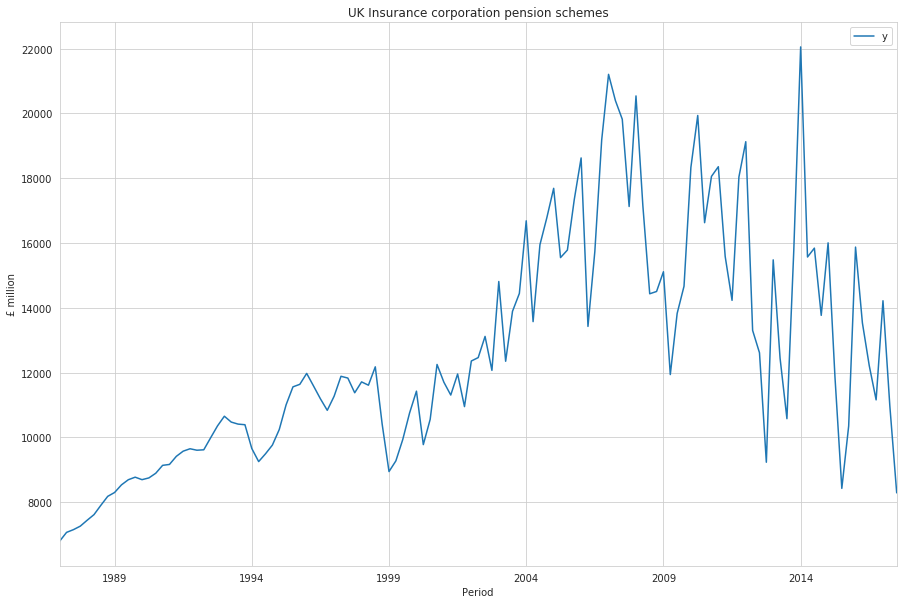

In [27]:
ax = df.set_index('ds').plot(figsize=(15, 10))
ax.set_title('UK Insurance corporation pension schemes')
ax.set_ylabel('£ million')
ax.set_xlabel('Period')
plt.show()

### Set the uncertainty interval to 95% (the Prophet default is 80%)

In [28]:
my_model = Prophet(interval_width=0.95)

In [29]:
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_dates = my_model.make_future_dataframe(periods=40, freq='Q')
future_dates.tail()

,ds
158,2026-09-30
159,2026-12-31
160,2027-03-31
161,2027-06-30
162,2027-09-30


In [31]:
forecast = my_model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
158,2026-09-30,10240.141785,6174.221504,14231.828119
159,2026-12-31,10636.325024,6787.040598,14530.848114
160,2027-03-31,11732.601662,7585.128347,15684.104996
161,2027-06-30,10368.196871,6386.444139,14542.056241
162,2027-09-30,10009.404305,6115.865279,13939.283592


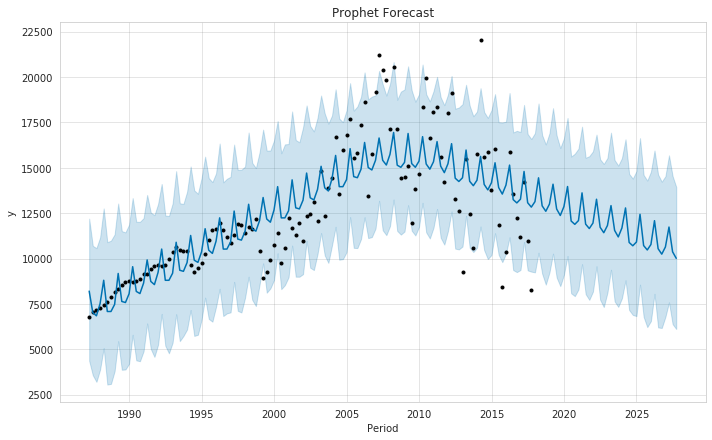

In [32]:
my_model.plot(forecast, uncertainty=True)
plt.xlabel('Period')
plt.title('Prophet Forecast')
plt.show()

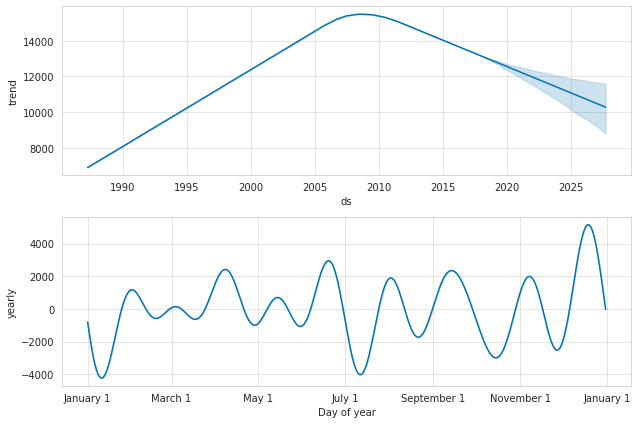

In [33]:
my_model.plot_components(forecast)
plt.show()

# Anomaly Detection - Seasonal decomposition
#### Seasonal decomposition using moving averages.
Return a object with seasonal, trend, and resid attributes.

In [36]:
df = pd.read_csv('data.csv')
df.set_index(['date'], inplace=True)
ts = df.copy()
ts.index.name=None

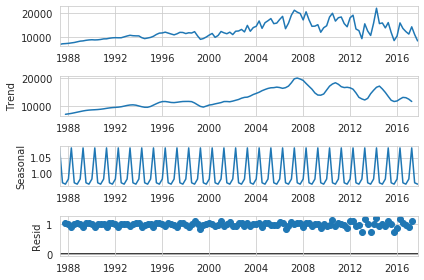

In [57]:
series = pd.read_csv('data.csv', index_col=0, parse_dates=True, header = 0)
result = seasonal_decompose(series, model = 'multiplicative')
result.plot()
plt.show()

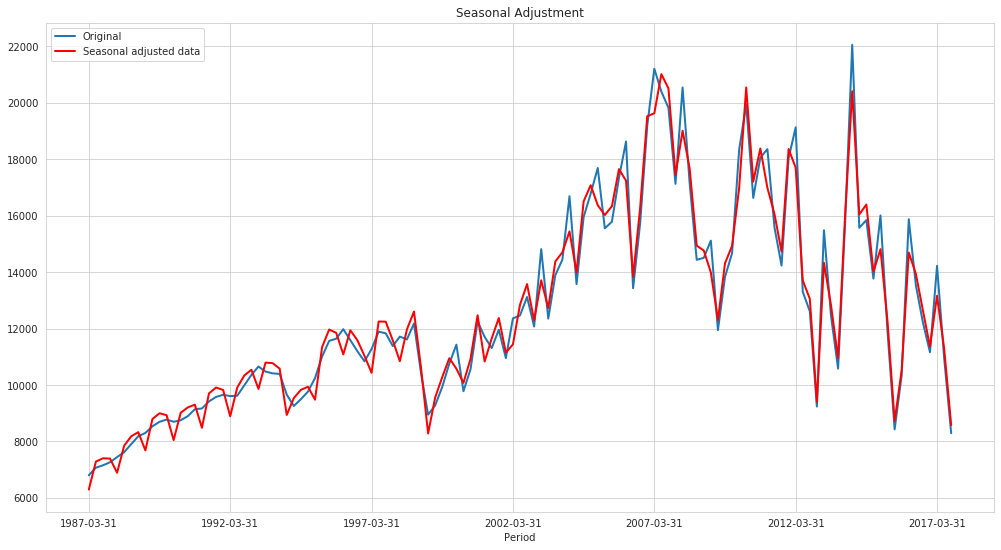

In [58]:
seas_res = result.seasonal
seas_adj = ts['value'] / seas_res
ts['seas_adj_data'] = seas_adj
ts['seas_res'] = seas_res
plt.figure(figsize=(17, 9))
ts['value'].plot(linewidth = 2,label = 'Original')
ts['seas_adj_data'].plot(color = 'red', linewidth = 2, label = "Seasonal adjusted data")
plt.xlabel('Period')
plt.title('Seasonal Adjustment')
plt.legend()

In [59]:
ts.head()

,value,seas_adj_data,seas_res
1987-03-31,6801,6293.915399,1.080567
1987-06-30,7070,7284.193502,0.970595
1987-09-30,7154,7402.903626,0.966378
1987-12-31,7262,7391.647679,0.982460
1988-03-31,7444,6888.973126,1.080567


## Draw seasonal coefficient by quarters

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 0, 'Quarters')

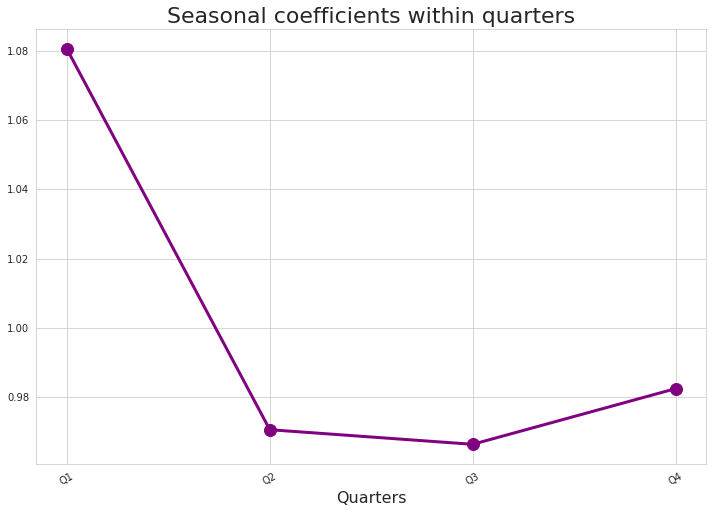

In [60]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.plot(ts['seas_res'].drop_duplicates(), linewidth = 3, color = 'purple', marker = 'o', markersize = 12)
labels = ax.set_xticklabels(['Q1','Q2','Q3','Q4'],rotation = 30)
plt.title('Seasonal coefficients within quarters', fontsize = 22)
plt.xlabel('Quarters', fontsize = 16)


# Anomaly Detection - Outliers - Luminol - https://github.com/linkedin/luminol
Given a time series, detect if the data contains any anomaly and gives you back a time window where the anomaly happened in, a time stamp where the anomaly reaches its severity, and a score indicating how severe is the anomaly compare to others in the time series.

Try use AnomalyDetector class for detecting anomaly in time series of Insurance corporations and pension funds (£ million).

In [61]:
data = np.array(ts['value'])
ts_s = pd.Series(data)
ts_dict = ts_s.to_dict()
ts_dict

{0: 6801,
 1: 7070,
 2: 7154,
 3: 7262,
 4: 7444,
 5: 7618,
 6: 7906,
 7: 8182,
 8: 8301,
 9: 8536,
 10: 8695,
 11: 8774,
 12: 8697,
 13: 8751,
 14: 8895,
 15: 9139,
 16: 9167,
 17: 9417,
 18: 9577,
 19: 9651,
 20: 9606,
 21: 9619,
 22: 9990,
 23: 10356,
 24: 10655,
 25: 10475,
 26: 10412,
 27: 10393,
 28: 9659,
 29: 9255,
 30: 9496,
 31: 9764,
 32: 10243,
 33: 11008,
 34: 11562,
 35: 11640,
 36: 11977,
 37: 11588,
 38: 11194,
 39: 10837,
 40: 11273,
 41: 11888,
 42: 11833,
 43: 11379,
 44: 11715,
 45: 11613,
 46: 12180,
 47: 10414,
 48: 8947,
 49: 9277,
 50: 9933,
 51: 10757,
 52: 11429,
 53: 9779,
 54: 10558,
 55: 12253,
 56: 11704,
 57: 11309,
 58: 11958,
 59: 10952,
 60: 12360,
 61: 12465,
 62: 13119,
 63: 12071,
 64: 14814,
 65: 12352,
 66: 13894,
 67: 14445,
 68: 16687,
 69: 13575,
 70: 15950,
 71: 16779,
 72: 17690,
 73: 15552,
 74: 15784,
 75: 17339,
 76: 18628,
 77: 13428,
 78: 15739,
 79: 19182,
 80: 21208,
 81: 20398,
 82: 19822,
 83: 17129,
 84: 20542,
 85: 17156,
 86: 1443

In [62]:
detector = luminol.anomaly_detector.AnomalyDetector(ts_dict)
anomalies = detector.get_anomalies()

/home/sanya/anaconda3/envs/ml0/lib/python3.8/site-packages/luminol/modules/time_series.py:337: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead



In [63]:
#Scoring
score = detector.get_all_scores()
score_dict = {}
for item, value in score.iteritems():
    score_dict[item] = value
score_dict

{0: 0.0,
 1: 0.06092879736157683,
 2: 0.11648906264590769,
 3: 0.09969411926480048,
 4: 0.10416514037554193,
 5: 0.12274330464584,
 6: 0.163426962081483,
 7: 0.19325587476479666,
 8: 0.18155833135840851,
 9: 0.198474424863569,
 10: 0.1947932156547612,
 11: 0.17372815985304518,
 12: 0.12154194276406635,
 13: 0.1113290178315153,
 14: 0.12018785030612916,
 15: 0.15141654997064571,
 16: 0.13412808734016038,
 17: 0.15860549310126312,
 18: 0.16312457135035002,
 19: 0.1472607388823495,
 20: 0.10761604136137747,
 21: 0.10027797963424573,
 22: 0.20717670032176322,
 23: 0.2176681589788953,
 24: 0.23341089856895328,
 25: 0.14595851987715536,
 26: 0.12398278532289238,
 27: 0.11361770510401661,
 28: 0.2971369526583799,
 29: 0.1747835590628038,
 30: 0.08524008084080097,
 31: 0.010563181805510892,
 32: 0.14469033555129107,
 33: 0.34036691885350934,
 34: 0.32970170638771834,
 35: 0.3237678412824959,
 36: 0.3014736335982285,
 37: 0.15306997686500118,
 38: 0.03321454595125223,
 39: 0.054289257878711875,

In [64]:
from operator import itemgetter
score_dict_sorted = sorted(score_dict.items(), key=itemgetter(1))

In [65]:
#Results
top_three_anom = score_dict_sorted[-3:]
for anom in top_three_anom:
    print ('Position = {}, Value = {}'.format(anom[0], anom[1]))

Position = 77, Value = 1.9285394682291854
Position = 101, Value = 2.0662272625150586
Position = 108, Value = 3.203801421063209


# Anomaly Detection - Outlier Detector - 'Sigma Rule'

In [66]:
df = pd.read_csv('data.csv')
df.set_index(['date'], inplace=True)
ts = df.copy()
ts.index.name=None

## 1.Two sigmas rule = probability 0,9544

In [67]:
def reject_outliers(data):
    mean = np.mean(data.value)
    std = np.std(data.value)
    data_filtered = data[(data.value > mean-2*std) & (data.value < mean+2*std)]
    data_anomaly = data[(data.value < mean-2*std) | (data.value > mean+2*std)] 
    if data_anomaly.empty:
        print ("Anomalies were not detected")
        
    else:
        print ("Anomalies were detected")
    return data_filtered, data_anomaly

anomaly_cleared, anomaly_list = reject_outliers(ts)
anomaly_list

Anomalies were detected


,value
2007-03-31,21208
2007-06-30,20398
2007-09-30,19822
2008-03-31,20542
2010-06-30,19939
2014-03-31,22055


## 2.Three sigmas rule = probability 0,9973

In [68]:
def reject_outliers(data):
    mean = np.mean(data.value)
    std = np.std(data.value)
    data_filtered = data[(data.value > mean-3*std) & (data.value < mean+3*std)]
    data_anomaly = data[(data.value < mean-3*std) | (data.value > mean+3*std)] 
    if data_anomaly.empty:
        print ("Anomalies were not detected")
    else:
        print ("Anomalies were detected")
    return data_filtered, data_anomaly

anomaly_cleared, anomaly_list = reject_outliers(ts)
anomaly_list

Anomalies were not detected


,value


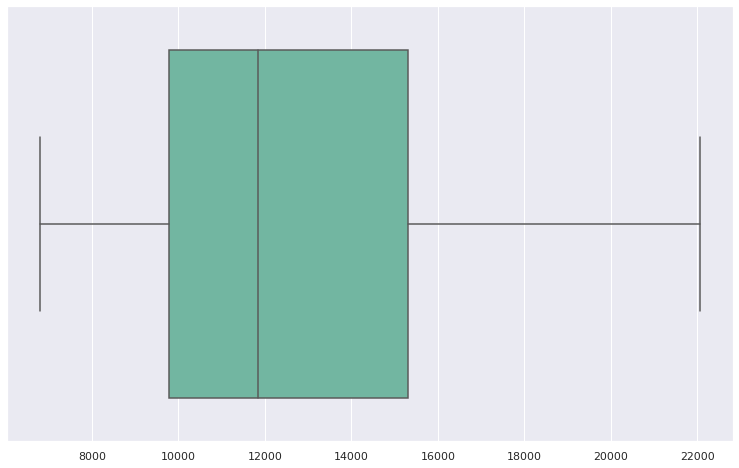

In [69]:
#Boxplot
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(13,8)})
sns.boxplot(ts, palette='Set2')

# Outlier Adjustment - Winsorizing / https://en.wikipedia.org/wiki/Winsorizing

Winsorizing or winsorization is the transformation of statistics by limiting extreme values in the statistical data to reduce the effect of possibly spurious outliers. 

### 90% winsorization. Limits param's value is 0.05 means that the 5% of the lowest value and the 5% of the highest values are replaced.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<ipython-input-70-e4ee766a1f45>:13: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>



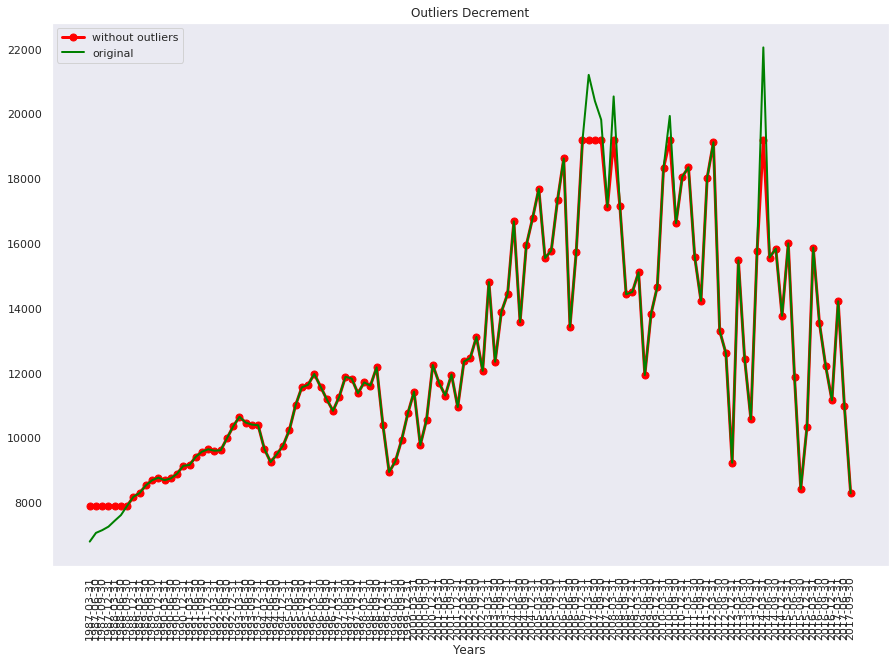

In [70]:
#1. 90% winsorization
a = ts['value']
res = np.array(stats.mstats.winsorize(a, limits=0.05))
plt.figure(figsize = (15,10))
plt.legend(loc=2)
plt.plot(res, color = 'red', marker = 'o', markersize=7, linewidth = 3, label = 'without outliers')
plt.plot(a, color = 'green', label = 'original', linewidth = 2)
plt.legend(loc=2)
plt.title('Outliers Decrement')
plt.xlabel('Years')
plt.grid()
plt.xticks(rotation=90)
plt.locator_params(nbins=100, axis = 'x')

### 80% winsorization. Limits param's value is 0.1 means that the 10% of the lowest and highest values are replaced.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
<ipython-input-71-0303379e1d42>:13: UserWarning:

'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>



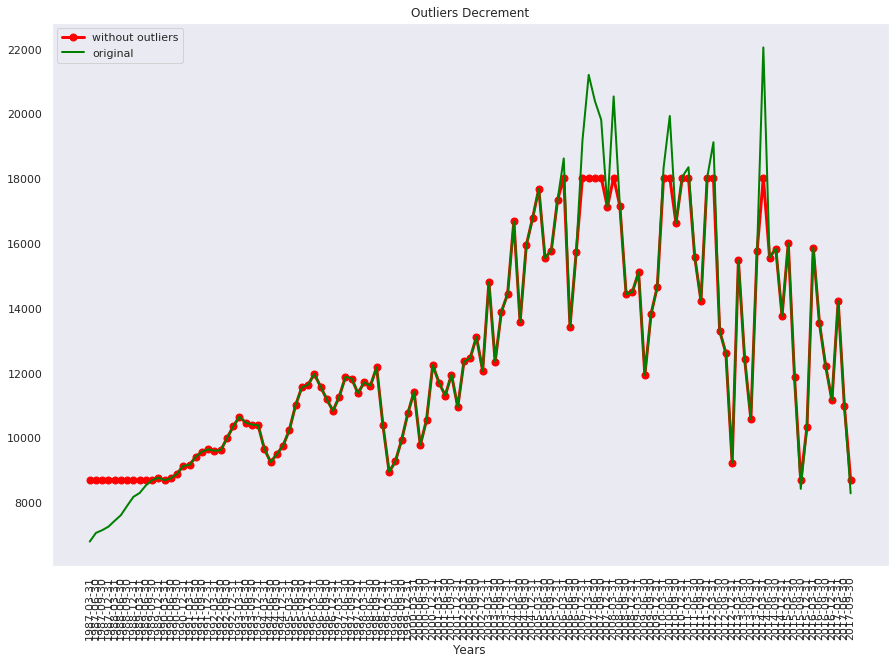

In [71]:
#2. 80% winsorization
a = ts['value']
res = np.array(stats.mstats.winsorize(a, limits=0.1))
plt.figure(figsize = (15,10))
plt.legend(loc=2)
plt.plot(res, color = 'red', marker = 'o', markersize=7,linewidth = 3, label = 'without outliers')
plt.plot(a, color = 'green', label = 'original', linewidth = 2)
plt.legend(loc=2)
plt.title('Outliers Decrement')
plt.xlabel('Years')
plt.grid()
plt.xticks(rotation=90)
plt.locator_params(nbins=100, axis = 'x')

# Bivariate Outliers - EllipticEnvelope model

## Data - World Happiness Report - https://www.kaggle.com/unsdsn/world-happiness/data

In [72]:
from sklearn.covariance import EllipticEnvelope

df1 = pd.read_csv("2017.csv")
country = df1["Country"]
params = ["Happiness.Score", "Economy..GDP.per.Capita."]
params_data = np.array([df1[params[0]], df1[params[1]]]).T
df1.head()

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

<frozen importlib._bootstrap>:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



,Country,Happiness.Rank,Happiness.Score,Whisker.high,Whisker.low,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,Norway,1,7.537,7.594445,7.479556,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,Denmark,2,7.522,7.581728,7.462272,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,Iceland,3,7.504,7.622030,7.385970,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,Switzerland,4,7.494,7.561772,7.426227,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,Finland,5,7.469,7.527542,7.410458,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [73]:
ee = EllipticEnvelope()
ee.fit(params_data)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
                 store_precision=True, support_fraction=None)

In [74]:
biv_outliers_mask = ee.predict(params_data) == -1
biv_outliers_data = params_data[biv_outliers_mask]
biv_outliers_name = country[biv_outliers_mask]

In [75]:
xx, yy = np.meshgrid(np.linspace(params_data[:, 0].min(), params_data[:, 0].max(), 100),
                     np.linspace(params_data[:, 1].min(), params_data[:, 1].max(), 100))
zz = ee.decision_function(np.c_[xx.ravel(), yy.ravel()])
zz = zz.reshape(xx.shape)

Text(0, 0.5, 'Economy..GDP.per.Capita.')

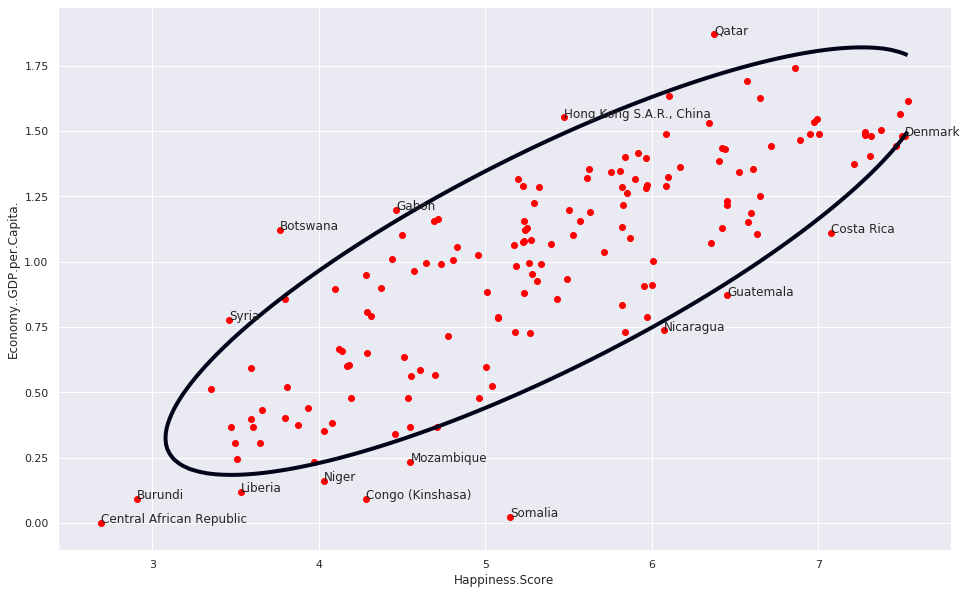

In [78]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 1, 1)
for name, xy in zip(biv_outliers_name, biv_outliers_data):
    ax.text(xy[0], xy[1], name)
ax.contour(xx, yy, zz, levels=[0], linewidths=4)
ax.scatter(params_data[:, 0], params_data[:, 1], color='red')
ax.set_xlabel(params[0])
ax.set_ylabel(params[1])

# Thank you!